In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from string import punctuation
import matplotlib.pyplot as plt

In [2]:
stopwords_en = set(stopwords.words('english'))
stopwords_with_punct = stopwords_en.union(set(punctuation))

data = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)

- I have used sentiment140 dataset from kaggle the problem statement 
- This is a labeled dataset of 1.6 Million tweets
##### data: https://www.kaggle.com/kazanova/sentiment140

In [3]:
data.columns = ('target','uid', 'time', 'query', 'user', 'text')

#### Preprocessing
- In the preprocessing, I have removed all the hastags, @userids, urls as well as punctuation
- Tweets are converted to lowercase, as well as, punctuation has been removed from words
- EG: 'views,'   ---->    'views' 

In [4]:
def preprocess_text(tweet):
    tweet = tweet.lower()
    # remove urls, if any
    tweet = re.sub(r'((https?:\/\/)|(www\.))[A-Za-z0-9.\/]+', '',  tweet)
    tweet = re.sub(r'[A-Za-z0-9]+.com', '',tweet)
    # remove #s, @users, if any
    tweet = re.sub(r'[@#][A-Za-z0-9]+', '',tweet)
    # remove non-ascii characters
    tweet = ''.join([w for w in tweet if ord(w)<128])
    # remove punctuation only
    tweet = ' '.join([w.strip(punctuation) for w in tweet.split() if w not in punctuation])
    # remove stopwords, punctuation
    # do not remove stopwords, sometime tweet becomes meaningless,
    # WE MAY LOOSE IMPORTANT SENTIMENT INFORMATION
#     tweet = [w.strip(punctuation) for w in tweet.lower().split() if w not in stopwords_with_punct]
    # remove words that contains numeric
#     tweet = ' '.join([w for w in tweet if w.isalpha()])
    return tweet

#### select 150 random tweets, 75 from each class
- Due to lack of computational power only 150 tweets has been taken from full dataset
- And on these tweets, a POC has been completed

In [5]:
data['target'].unique()

array([0, 4])

In [6]:
random_data_150 = pd.DataFrame(None, columns=data.columns)

In [7]:
random_data_150 = random_data_150.append(data[data['target']==0].sample(n=75, random_state=1))
random_data_150 = random_data_150.append(data[data['target']==4].sample(n=75, random_state=1))

In [8]:
random_data_150.head(2)

,target,uid,time,query,user,text
670935,0,2246713398,Fri Jun 19 18:00:49 PDT 2009,NO_QUERY,Mickie_1,"@TheRealScarab PA system bugs are a bummer, so..."
649589,0,2237331866,Fri Jun 19 05:36:56 PDT 2009,NO_QUERY,supaflya,oh daaamnnn! the firemen ball's on the 14th an...


In [9]:
%%time
random_data_150['text'] = random_data_150['text'].apply(preprocess_text)

CPU times: user 6.24 ms, sys: 118 µs, total: 6.36 ms
Wall time: 6.28 ms


#### Create Vocabulary
- Vocubulary: is set of unique words appearing in our dataset

In [10]:
combined_sentence = ' '.join([tweet for tweet in random_data_150['text'].values])

In [11]:
vocabulary = set(combined_sentence.split())
len(vocabulary)

849

#### word to index dictionary

In [12]:
word_to_ix = {word:index for index,word in enumerate(vocabulary)}

### Trigram train data

- Trigrams are created by sliding window mechanism
- Eg: Cleaned tweet: pa system bugs are a bummer sorry ;;; Sentiment = negative = 0 = [0,1]
- Below is all possible tupples in following format: ([CONTEXT Words], sentiment)
- (['pa', 'system', 'bugs'], [0, 1]),
- (['system', 'bugs', 'are'], [0, 1]),
- (['bugs', 'are', 'a'], [0, 1]),
- (['are', 'a', 'bummer'], [0, 1]),
- (['a', 'bummer', 'sorry'], [0, 1]),

* positive sentiment in the code is represented as [1,0]


In [13]:
trigrams = []

for index, row in random_data_150.iterrows():
    tweet = row['text']
    sentiment = [0,1] if row['target']==0 else [1,0]
    tweet_grams = []
    tweet = tweet.split()
    for i in range(len(tweet)-2):
        tweet_grams.append(([tweet[i], tweet[i+1], tweet[i+2]], sentiment))
    trigrams.extend(tweet_grams)

In [14]:
trigrams[:5]

[(['pa', 'system', 'bugs'], [0, 1]),
 (['system', 'bugs', 'are'], [0, 1]),
 (['bugs', 'are', 'a'], [0, 1]),
 (['are', 'a', 'bummer'], [0, 1]),
 (['a', 'bummer', 'sorry'], [0, 1])]

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

### Trigrams to id tensors
- As every word has an unique index id, saved in word_to_ix dictionary
- I used these ids to uniquely represent word throughout the excercise
- By using these ids,  tensors are created, so that these can be further used in network

In [16]:
trigram_tens = []

for context, target in trigrams:
    context_ids = [word_to_ix[word] for word in context]
    context_tens = torch.tensor(context_ids, dtype=torch.long)
    target_tens = torch.tensor([target], dtype=torch.float)
    trigram_tens.append((context_tens, target_tens))

In [17]:
trigram_tens[:5]

[(tensor([769, 846,  60]), tensor([[0., 1.]])),
 (tensor([846,  60, 249]), tensor([[0., 1.]])),
 (tensor([ 60, 249, 341]), tensor([[0., 1.]])),
 (tensor([249, 341, 773]), tensor([[0., 1.]])),
 (tensor([341, 773, 281]), tensor([[0., 1.]]))]

###  Model
- The model below is created using pytorch framework, with the SSWEh architecture as described in the paper

#### model parameters as used in paper

In [18]:
CONTEXT_LEN = 3
VOCAB_SIZE = len(vocabulary)
EMBEDDING_DIM = 50
HIDDEN_LAYER_LEN = 20
AdagradLearningRate = 0.1

In [19]:
class SSWEh(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_len):
        super(SSWEh, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_len*embedding_dim, HIDDEN_LAYER_LEN)
        self.linear2 = nn.Linear(HIDDEN_LAYER_LEN, 2)
    
    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1,-1))
        out = F.hardtanh(self.linear1(embeds))
        out = self.linear2(out)
        return F.softmax(out, dim=1)

## Training

In [20]:
losses = []
loss_function = nn.BCELoss()
model = SSWEh(VOCAB_SIZE, EMBEDDING_DIM, CONTEXT_LEN)
optimizer = optim.Adagrad(model.parameters(), lr=AdagradLearningRate)

In [21]:
print(model)

SSWEh(
  (embeddings): Embedding(849, 50)
  (linear1): Linear(in_features=150, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=2, bias=True)
)


In [24]:
out1 = model(trigram_tens[0][0])

In [25]:
loss_function(out1, trigram_tens[0][1])

tensor(0.5229, grad_fn=<BinaryCrossEntropyBackward>)

In [26]:
%%time
for epoch in range(300):
    total_loss = 0
    for context_tens, target_tens in trigram_tens:
        model.zero_grad()
        softmax_out = model(context_tens)
        loss = loss_function(softmax_out, target_tens)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(total_loss)
    losses.append(total_loss)

165.99963979702443
138.57342564681312
149.47877428110223
159.62153350550216
167.90054731501732
176.7995135113597
182.16312013514107
186.2392294727033
184.61669619908207
185.52291351158055
186.17483549432654
183.85301580491068
180.9221729891142
181.45770831560367
182.7355064909425
178.61551707924082
173.51494061913036
176.0633013846127
173.86326930986434
172.53049190782622
171.00548558058108
170.5324839828827
169.90764975515776
169.18359960038651
169.45345517349688
170.10726312908082
168.5256027981095
162.8951077171314
156.49025287106724
154.19312223268116
150.81631682362513
148.3521343557877
146.28216703921544
145.46708493982806
145.19550392858582
144.30061491222182
143.81905761342387
143.529783095502
143.49207711946224
143.38533904841927
143.6694676760569
144.53562700979433
138.79294784889953
133.89607406756164
131.59263600669505
129.4632853211216
124.38855014157849
121.35034079921613
120.37951015879005
119.66234214080865
119.38022612573764
117.30957235301034
116.67911856363494
116.37

- Training is done twice on the same dataset, 1st time 150 epoch 
- in this case 122 to 104 training loss reduced
- Below is graph for the same

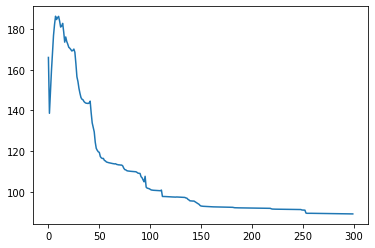

In [27]:
plt.plot(range(len(losses)), losses)

- 2nd time training with 300 epochs 
- here loss coverged from 104 to 85
- Below is graph presented for combined training losses i.e. for case1 + case 2
- so below graph represents 122 to 85 training loss
- in the both cases we clearly see the loss is decreasing, hence network is learning

### Again training for 300 epochs

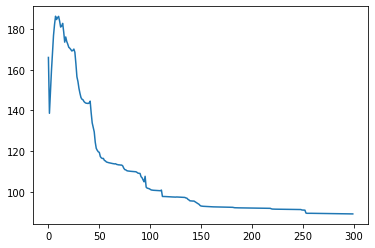

In [28]:
plt.plot(range(len(losses)), losses)

In [29]:
# torch.save(model.state_dict(), 'model.bin')

### Extracting embedding layer from trained model parameters

In [30]:
embed_layer = None
for i in model.parameters():
    embed_layer = i.data
    print(i.data.shape)
    break

torch.Size([849, 50])


- Below is the embedding layer extracted that we trained

In [31]:
embed_layer

tensor([[-1.2840, -0.8519, -0.7590,  ..., -0.7592, -1.0658,  0.6643],
        [ 0.4425, -0.1786,  1.3648,  ...,  0.7801,  1.2069, -1.2186],
        [ 1.5396, -0.9426, -0.9864,  ...,  0.5098,  0.3215, -0.2727],
        ...,
        [ 0.5529, -1.4446,  1.4333,  ..., -1.1565, -0.7788, -0.9231],
        [ 1.8853,  2.0379, -0.1262,  ...,  0.0783, -0.9059,  0.6963],
        [ 1.5212,  0.6717,  0.4253,  ..., -1.1038,  0.0337, -1.1610]])

In [32]:
# torch.save(embed_layer, 'embed_layer_tensor.bin')

#### Visulisation of Embeddings using TSNE
- TSNE is a dimensionality reduction technique
- Our embedding layer is in 849x50 shape, as we had 849 words in our vocubulary
- It will be reduced to 849x2 shape by using TSNE

In [33]:
from sklearn.manifold import TSNE

In [34]:
%%time
tsne = TSNE(n_components=2, random_state=1, n_iter=10000, metric="cosine")
reduced_dim = tsne.fit_transform(embed_layer.numpy())

CPU times: user 54.1 s, sys: 404 ms, total: 54.5 s
Wall time: 6.96 s


In [35]:
reduced_dim

array([[ -4.9153547 , -19.947256  ],
       [ 21.255333  ,   1.3857838 ],
       [ 16.721697  ,  17.245922  ],
       ...,
       [-25.07539   ,   0.08242349],
       [-10.379233  ,  -6.575523  ],
       [ 28.376736  , -12.932473  ]], dtype=float32)

In [36]:
reduced_dim.shape

(849, 2)

In [38]:
import seaborn as sns

In [39]:
reduced_we_df = pd.DataFrame(reduced_dim, columns=('x','y'))

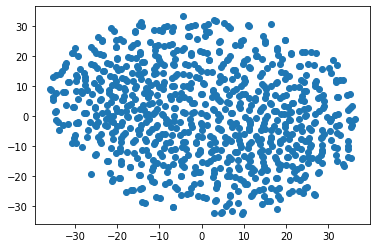

In [40]:
plt.scatter(reduced_we_df['x'], reduced_we_df['y'], )

### PCA dim reduction

In [43]:
from sklearn.decomposition import PCA

In [44]:
pca = PCA(n_components=2)
pca_reduced = pca.fit_transform(embed_layer.numpy())

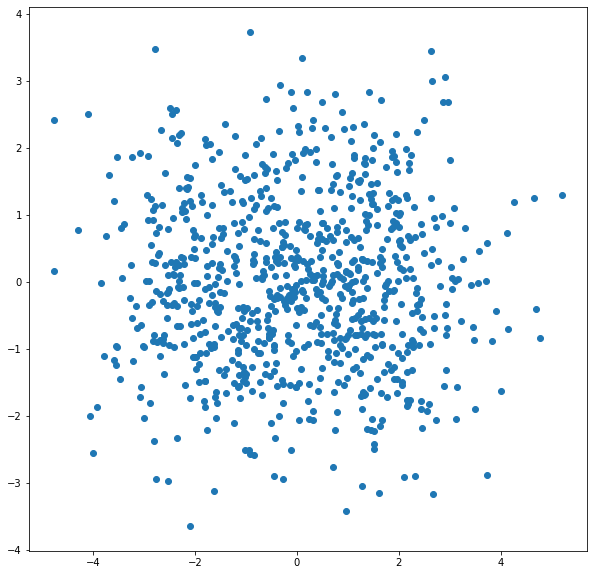

In [45]:
plt.figure(figsize=(10,10))
plt.scatter(pca_reduced[:,0], pca_reduced[:,1])

In [46]:
pd.Series(reduced_dim[:,1]).quantile([0,0.25, 0.5, 0.9, 0.99, 1])

0.00   -32.473843
0.25   -10.857988
0.50     0.573869
0.90    20.963549
0.99    30.231928
1.00    33.232300
dtype: float64

In [47]:
from sklearn.preprocessing import StandardScaler

In [48]:
sc = StandardScaler()
red_nor = sc.fit_transform(reduced_dim)

In [49]:

pd.Series(red_nor[:,0]).quantile([0,0.25, 0.5, 0.9, 0.99, 1])

0.00   -2.000429
0.25   -0.825745
0.50    0.006266
0.90    1.341782
0.99    1.876094
1.00    1.953634
dtype: float64

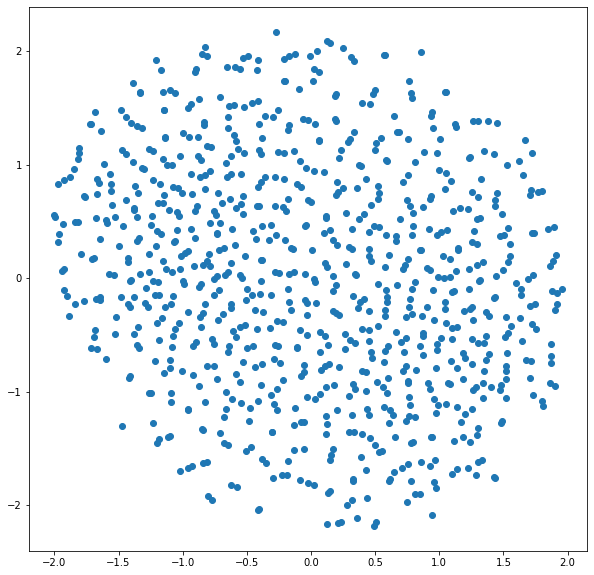

In [50]:
plt.figure(figsize=(10,10))
plt.scatter(red_nor[:,0], red_nor[:,1])

- In both the cases, using pca or tsne, it is expected that the words will form clusters
- However, due to lack of computational power, i took only 150 tweets, with 849 unique words
- This dataset is very less, 
- also we can increase number of epochs in training
- Network architecture could be updated
- Using above methods, certainly we will get clusters because words share common properties or semantics
- And training word embedding would capture these semantics

#### Plotting only particular words from reduced dimension

In [51]:
words = ['sunday', 'tonight', 'tomorrow', 'evening', 'weeks', 'nights', 'night', 'wednesday', 'tuesday', 'monday', 'days', 'weekend', 'friday', 'april', '14th', 'seconds', 'tomm']

In [52]:
len(words)

17

In [53]:
word_indexes = [word_to_ix[word] for word in words]

In [54]:
word_indexes

[532,
 797,
 626,
 235,
 394,
 670,
 848,
 164,
 329,
 368,
 39,
 571,
 353,
 666,
 708,
 580,
 227]

In [55]:
word_vals_by_reduced_embed_layer = reduced_dim[word_indexes, :]

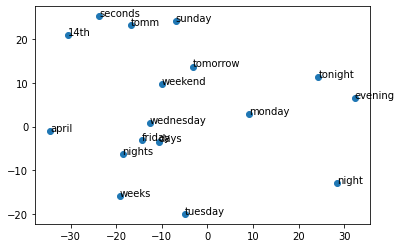

In [56]:
plt.scatter(word_vals_by_reduced_embed_layer[:,0], word_vals_by_reduced_embed_layer[:,1])
for index, word in enumerate(words):
    plt.annotate(word, tuple(word_vals_by_reduced_embed_layer[index]))